GAN:https://arxiv.org/pdf/1406.2661.pdf  
DCGAN:https://arxiv.org/pdf/1511.06434.pdf


In [80]:
from tqdm import tqdm
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import urllib.request
import zipfile
import tarfile

import torch
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt

### データ収集

In [64]:
# MNISTの手書き数字画像をダウンロードし読み込みます（2分ほど時間がかかります）
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  
# data_homeは保存先を指定します

In [67]:
# フォルダ「data」の下にフォルダ「img_269」を作成する
data_dir_path = "./data/img_269/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [69]:
# データの取り出し
X = mnist.data
y = mnist.target

In [72]:
# MNISTから数字2,6,9の画像だけフォルダ「img_269」に画像として保存していく
count2=0
count6=0
count9=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像2の作成
    if (y[i] is "2") and (count2<max_num):
        file_path="./data/img_269/img_2_"+str(count2)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count2+=1 
    
    # 画像6の作成
    if (y[i] is "6") and (count6<max_num):
        file_path="./data/img_269/img_6_"+str(count6)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count6+=1 
        
    # 画像9の作成
    if (y[i] is "9") and (count9<max_num):
        file_path="./data/img_269/img_9_"+str(count9)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count9+=1 


### Generatorの実装

In [73]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8,
                              kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                              stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

tensor([[ 0.5088, -0.9194, -0.2770, -2.6658, -0.0743, -1.9582,  0.7275, -0.7010,
         -0.4965,  0.2088, -0.7903, -3.5576, -0.9668,  0.6231,  0.9150,  0.9417,
          0.1612,  0.1815,  0.5592,  0.8054]])
torch.Size([1, 1, 64, 64])


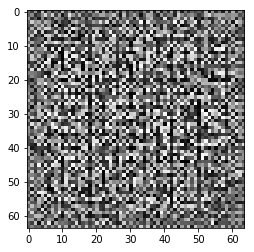

In [74]:
## 動作確認

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1,20)
print(input_z)
# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)
print(fake_images.size())
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')

In [75]:
samples = []
# 入力する乱数
input_z = torch.randn(9, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

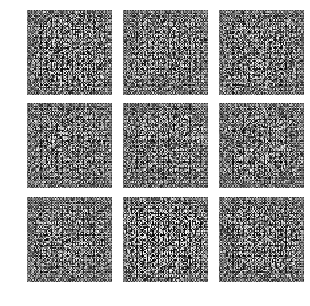

In [76]:
fig, axes = plt.subplots(figsize=(5,5), nrows=3, ncols=3,sharey=True, sharex=True)
for ax, fake_image in zip(axes.flatten(), fake_images):
    ax.axis('off')
    img = fake_image.view(1, 1, fake_image.size(1), fake_image.size(2))
    img_transformed = img[0][0].detach().numpy()
    im = ax.imshow(img_transformed, 'gray')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

### Discriminatorの実装

In [77]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                     stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                     stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                     stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                     stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [78]:
## 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
print(fake_images.size())
# 偽画像をDiscriminatorに
d_out = D(fake_images)

print(nn.Sigmoid()(d_out))

torch.Size([1, 1, 64, 64])
tensor([[[[0.4982]]]], grad_fn=<SigmoidBackward>)


### DataLoaderの作成

In [86]:
def make_datapath_list():
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = './data/img_269/img_2_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_269/img_6_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_269/img_9_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
    return train_img_list

class ImageTransform():
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        
        return img_transformed

In [87]:
# ファイルリストを作成
train_img_list = make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size=64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作確認
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


### 学習

In [88]:
## ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [95]:
# 学習関数
def train_model(G, D, dataloader, num_epochs):
    
    ## GPU
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('デバイス:',device)
    
    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 誤差関数
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size=64
    
    ## GPUに流す
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    ## ネットワーク固定
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウント
    iteration = 1
    d_loss_logs = []
    g_loss_logs = []
    images = []
    
    # epochのループ
    for epoch in range(num_epochs):
        
        # 開始時刻
        t_epoch_start = time.time()
        
        # epochの損失和
        epoch_g_loss = 0.0
        epoch_d_loss= 0.0
        
        print('-'*20)
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-'*20)
        print('(train)')
        
        # ミニバッチごとに
        for imges in dataloader:
            
            # ---------------------
            # Discriminatorの学習
            # ---------------------
            if imges.size()[0] == 1:
                continue
            
            imges = imges.to(device)
            
            # 正解ラベルと偽ラベルを作成
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,),1).to(device)
            label_fake = torch.full((mini_batch_size,),0).to(device)
            
            # 真の画像を判定
            d_out_real = D(imges)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            # ---------------------
            # Generatorの学習
            # ---------------------
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # ---------------------
            # 記録
            # ---------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        # 結果格納
        d_loss_logs.append(epoch_d_loss)
        g_loss_logs.append(epoch_g_loss)
        
        # 途中経過の保存
        if epoch%10 == 0:
            # 偽の画像を生成
            input_z = torch.randn(5, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            images.append(fake_images)
            
    return G, D, images

In [99]:
# 学習検証
num_epochs = 500
G_update, D_update, images = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

デバイス: cuda:0
--------------------
Epoch 0/500
--------------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1170 ||Epoch_G_Loss:0.6405
timer:  0.5918 sec.
--------------------
Epoch 1/500
--------------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1716 ||Epoch_G_Loss:0.5447
timer:  0.5774 sec.
--------------------
Epoch 2/500
--------------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1418 ||Epoch_G_Loss:0.4189
timer:  0.5656 sec.
--------------------
Epoch 3/500
--------------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.2050 ||Epoch_G_Loss:0.3236
timer:  0.5526 sec.
--------------------
Epoch 4/500
--------------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1580 ||Epoch_G_Loss:0.3265
timer:  0.5525 sec.
--------------------
Epoch 5/500
--------------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.1377 ||Epoch_G_Loss:0.3283
timer:  0.5639 sec.
--------------------
Epoch 6/500
--------------------
(train)
-------------
epoch 6 || Epoch_

-------------
epoch 54 || Epoch_D_Loss:0.1140 ||Epoch_G_Loss:0.3101
timer:  0.5601 sec.
--------------------
Epoch 55/500
--------------------
(train)
-------------
epoch 55 || Epoch_D_Loss:0.0904 ||Epoch_G_Loss:0.3602
timer:  0.5487 sec.
--------------------
Epoch 56/500
--------------------
(train)
-------------
epoch 56 || Epoch_D_Loss:0.1091 ||Epoch_G_Loss:0.2915
timer:  0.5518 sec.
--------------------
Epoch 57/500
--------------------
(train)
-------------
epoch 57 || Epoch_D_Loss:0.1110 ||Epoch_G_Loss:0.3319
timer:  0.5541 sec.
--------------------
Epoch 58/500
--------------------
(train)
-------------
epoch 58 || Epoch_D_Loss:0.0995 ||Epoch_G_Loss:0.3298
timer:  0.5437 sec.
--------------------
Epoch 59/500
--------------------
(train)
-------------
epoch 59 || Epoch_D_Loss:0.1123 ||Epoch_G_Loss:0.3297
timer:  0.5498 sec.
--------------------
Epoch 60/500
--------------------
(train)
-------------
epoch 60 || Epoch_D_Loss:0.1257 ||Epoch_G_Loss:0.3493
timer:  0.5436 sec.
------

-------------
epoch 109 || Epoch_D_Loss:0.0175 ||Epoch_G_Loss:0.6505
timer:  0.5469 sec.
--------------------
Epoch 110/500
--------------------
(train)
-------------
epoch 110 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.6035
timer:  0.5451 sec.
--------------------
Epoch 111/500
--------------------
(train)
-------------
epoch 111 || Epoch_D_Loss:0.0773 ||Epoch_G_Loss:0.5294
timer:  0.5469 sec.
--------------------
Epoch 112/500
--------------------
(train)
-------------
epoch 112 || Epoch_D_Loss:0.0150 ||Epoch_G_Loss:0.6983
timer:  0.5442 sec.
--------------------
Epoch 113/500
--------------------
(train)
-------------
epoch 113 || Epoch_D_Loss:0.0710 ||Epoch_G_Loss:0.6517
timer:  0.5492 sec.
--------------------
Epoch 114/500
--------------------
(train)
-------------
epoch 114 || Epoch_D_Loss:0.0499 ||Epoch_G_Loss:0.7035
timer:  0.5486 sec.
--------------------
Epoch 115/500
--------------------
(train)
-------------
epoch 115 || Epoch_D_Loss:0.0368 ||Epoch_G_Loss:0.6881
timer:  0.547

-------------
epoch 163 || Epoch_D_Loss:0.0428 ||Epoch_G_Loss:0.7620
timer:  0.5482 sec.
--------------------
Epoch 164/500
--------------------
(train)
-------------
epoch 164 || Epoch_D_Loss:0.0055 ||Epoch_G_Loss:0.9323
timer:  0.5460 sec.
--------------------
Epoch 165/500
--------------------
(train)
-------------
epoch 165 || Epoch_D_Loss:0.0677 ||Epoch_G_Loss:0.6816
timer:  0.5450 sec.
--------------------
Epoch 166/500
--------------------
(train)
-------------
epoch 166 || Epoch_D_Loss:0.0676 ||Epoch_G_Loss:0.9509
timer:  0.5479 sec.
--------------------
Epoch 167/500
--------------------
(train)
-------------
epoch 167 || Epoch_D_Loss:0.0450 ||Epoch_G_Loss:0.5526
timer:  0.5494 sec.
--------------------
Epoch 168/500
--------------------
(train)
-------------
epoch 168 || Epoch_D_Loss:0.0099 ||Epoch_G_Loss:0.9220
timer:  0.5435 sec.
--------------------
Epoch 169/500
--------------------
(train)
-------------
epoch 169 || Epoch_D_Loss:0.1087 ||Epoch_G_Loss:0.6381
timer:  0.567

-------------
epoch 217 || Epoch_D_Loss:0.0071 ||Epoch_G_Loss:0.9877
timer:  0.5752 sec.
--------------------
Epoch 218/500
--------------------
(train)
-------------
epoch 218 || Epoch_D_Loss:0.0794 ||Epoch_G_Loss:0.9448
timer:  0.5738 sec.
--------------------
Epoch 219/500
--------------------
(train)
-------------
epoch 219 || Epoch_D_Loss:0.0108 ||Epoch_G_Loss:0.8938
timer:  0.5781 sec.
--------------------
Epoch 220/500
--------------------
(train)
-------------
epoch 220 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.7873
timer:  0.5739 sec.
--------------------
Epoch 221/500
--------------------
(train)
-------------
epoch 221 || Epoch_D_Loss:0.0282 ||Epoch_G_Loss:0.9564
timer:  0.5753 sec.
--------------------
Epoch 222/500
--------------------
(train)
-------------
epoch 222 || Epoch_D_Loss:0.0514 ||Epoch_G_Loss:0.7694
timer:  0.5752 sec.
--------------------
Epoch 223/500
--------------------
(train)
-------------
epoch 223 || Epoch_D_Loss:0.0174 ||Epoch_G_Loss:1.1936
timer:  0.575

-------------
epoch 271 || Epoch_D_Loss:0.1348 ||Epoch_G_Loss:0.5505
timer:  0.5731 sec.
--------------------
Epoch 272/500
--------------------
(train)
-------------
epoch 272 || Epoch_D_Loss:0.0086 ||Epoch_G_Loss:0.9601
timer:  0.5744 sec.
--------------------
Epoch 273/500
--------------------
(train)
-------------
epoch 273 || Epoch_D_Loss:0.0132 ||Epoch_G_Loss:1.1418
timer:  0.5747 sec.
--------------------
Epoch 274/500
--------------------
(train)
-------------
epoch 274 || Epoch_D_Loss:0.0864 ||Epoch_G_Loss:0.7443
timer:  0.5762 sec.
--------------------
Epoch 275/500
--------------------
(train)
-------------
epoch 275 || Epoch_D_Loss:0.0055 ||Epoch_G_Loss:1.0802
timer:  0.5781 sec.
--------------------
Epoch 276/500
--------------------
(train)
-------------
epoch 276 || Epoch_D_Loss:0.0858 ||Epoch_G_Loss:0.8731
timer:  0.5744 sec.
--------------------
Epoch 277/500
--------------------
(train)
-------------
epoch 277 || Epoch_D_Loss:0.0161 ||Epoch_G_Loss:0.8715
timer:  0.574

-------------
epoch 325 || Epoch_D_Loss:0.0180 ||Epoch_G_Loss:1.1435
timer:  0.5757 sec.
--------------------
Epoch 326/500
--------------------
(train)
-------------
epoch 326 || Epoch_D_Loss:0.0626 ||Epoch_G_Loss:1.1832
timer:  0.5759 sec.
--------------------
Epoch 327/500
--------------------
(train)
-------------
epoch 327 || Epoch_D_Loss:0.0391 ||Epoch_G_Loss:0.6696
timer:  0.5759 sec.
--------------------
Epoch 328/500
--------------------
(train)
-------------
epoch 328 || Epoch_D_Loss:0.0075 ||Epoch_G_Loss:1.0387
timer:  0.5737 sec.
--------------------
Epoch 329/500
--------------------
(train)
-------------
epoch 329 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:1.0371
timer:  0.5766 sec.
--------------------
Epoch 330/500
--------------------
(train)
-------------
epoch 330 || Epoch_D_Loss:0.0067 ||Epoch_G_Loss:1.1270
timer:  0.5773 sec.
--------------------
Epoch 331/500
--------------------
(train)
-------------
epoch 331 || Epoch_D_Loss:0.0205 ||Epoch_G_Loss:1.2564
timer:  0.591

-------------
epoch 379 || Epoch_D_Loss:0.0014 ||Epoch_G_Loss:1.4464
timer:  0.5748 sec.
--------------------
Epoch 380/500
--------------------
(train)
-------------
epoch 380 || Epoch_D_Loss:0.0558 ||Epoch_G_Loss:1.0143
timer:  0.5755 sec.
--------------------
Epoch 381/500
--------------------
(train)
-------------
epoch 381 || Epoch_D_Loss:0.0037 ||Epoch_G_Loss:1.4978
timer:  0.5742 sec.
--------------------
Epoch 382/500
--------------------
(train)
-------------
epoch 382 || Epoch_D_Loss:0.0286 ||Epoch_G_Loss:1.0037
timer:  0.5736 sec.
--------------------
Epoch 383/500
--------------------
(train)
-------------
epoch 383 || Epoch_D_Loss:0.0492 ||Epoch_G_Loss:1.0341
timer:  0.5724 sec.
--------------------
Epoch 384/500
--------------------
(train)
-------------
epoch 384 || Epoch_D_Loss:0.0079 ||Epoch_G_Loss:1.1599
timer:  0.5795 sec.
--------------------
Epoch 385/500
--------------------
(train)
-------------
epoch 385 || Epoch_D_Loss:0.0283 ||Epoch_G_Loss:1.0800
timer:  0.576

-------------
epoch 433 || Epoch_D_Loss:0.0013 ||Epoch_G_Loss:1.5814
timer:  0.5739 sec.
--------------------
Epoch 434/500
--------------------
(train)
-------------
epoch 434 || Epoch_D_Loss:0.0402 ||Epoch_G_Loss:1.1792
timer:  0.5767 sec.
--------------------
Epoch 435/500
--------------------
(train)
-------------
epoch 435 || Epoch_D_Loss:0.0032 ||Epoch_G_Loss:1.5246
timer:  0.5768 sec.
--------------------
Epoch 436/500
--------------------
(train)
-------------
epoch 436 || Epoch_D_Loss:0.0512 ||Epoch_G_Loss:0.9091
timer:  0.5760 sec.
--------------------
Epoch 437/500
--------------------
(train)
-------------
epoch 437 || Epoch_D_Loss:0.0018 ||Epoch_G_Loss:1.4036
timer:  0.5746 sec.
--------------------
Epoch 438/500
--------------------
(train)
-------------
epoch 438 || Epoch_D_Loss:0.0473 ||Epoch_G_Loss:1.3581
timer:  0.5747 sec.
--------------------
Epoch 439/500
--------------------
(train)
-------------
epoch 439 || Epoch_D_Loss:0.0090 ||Epoch_G_Loss:1.2143
timer:  0.575

-------------
epoch 487 || Epoch_D_Loss:0.0013 ||Epoch_G_Loss:1.6545
timer:  0.5731 sec.
--------------------
Epoch 488/500
--------------------
(train)
-------------
epoch 488 || Epoch_D_Loss:0.0007 ||Epoch_G_Loss:1.8529
timer:  0.5777 sec.
--------------------
Epoch 489/500
--------------------
(train)
-------------
epoch 489 || Epoch_D_Loss:0.0665 ||Epoch_G_Loss:1.2213
timer:  0.5754 sec.
--------------------
Epoch 490/500
--------------------
(train)
-------------
epoch 490 || Epoch_D_Loss:0.0042 ||Epoch_G_Loss:1.3101
timer:  0.5763 sec.
--------------------
Epoch 491/500
--------------------
(train)
-------------
epoch 491 || Epoch_D_Loss:0.0269 ||Epoch_G_Loss:1.2096
timer:  0.5735 sec.
--------------------
Epoch 492/500
--------------------
(train)
-------------
epoch 492 || Epoch_D_Loss:0.0050 ||Epoch_G_Loss:1.3486
timer:  0.5731 sec.
--------------------
Epoch 493/500
--------------------
(train)
-------------
epoch 493 || Epoch_D_Loss:0.0012 ||Epoch_G_Loss:1.6029
timer:  0.577

### 学習の経過を見る

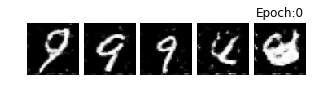

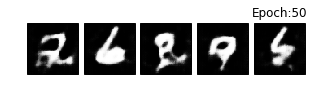

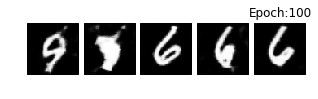

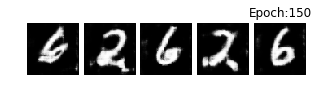

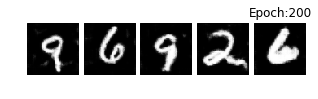

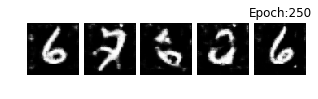

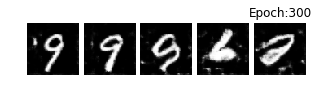

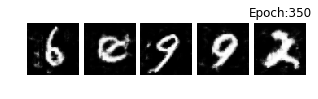

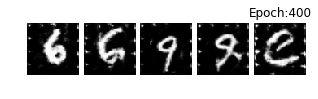

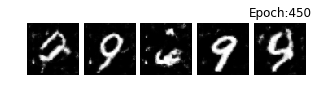

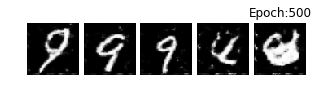

In [125]:
for i in range(0,51,5):
    aaa = images[i-1].cpu().detach().numpy().reshape(5,64,64)
    fig, axes = plt.subplots(figsize=(5,5), nrows=1, ncols=5,sharey=True, sharex=True) 
    for ax, img in zip(axes.flatten(), aaa):
        ax.axis('off')
        im = ax.imshow(img, 'gray')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.title('Epoch:'+str((i)*10))

学習が進むにつれて簡単に生成できる「９」ばかりになっていることがわかる

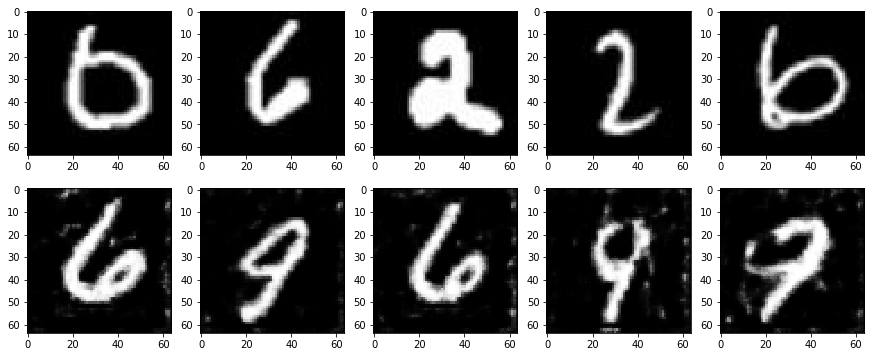

In [127]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')